In [1]:
import torch
from torch import nn

import numpy as np
from numpy import dtype
import matplotlib.pyplot as plt

from tqdm import trange

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

/home/loek/miniconda3/envs/rnn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available


In [2]:
## Generate data


def XOR_data(n_datapoints=100, seq_len=4):
    inputs = np.zeros([n_datapoints, seq_len, 1], dtype=np.float32)
    outputs = np.zeros([n_datapoints, 1], dtype=np.float32)
    for i in range(n_datapoints):
        # Generate input sequences
        for j in range(seq_len):
            bit = np.random.choice([0, 1])
            inputs[i, j, 0] = bit

        # Compute output
        problem = np.nansum(inputs[i]) % 2  # Parity
        # problem = np.sum(inputs[i]) ** 2 % 3  # Not multiple of 3
        outputs[i] = problem

    return inputs, outputs

In [3]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Defining the layers
        self.rnn = nn.RNN(
            input_size, hidden_dim, n_layers, batch_first=True, nonlinearity="relu"
        )
        self.fc = nn.Linear(hidden_dim, output_size)
        self.ReLU = nn.ReLU()

        # for par in self.rnn.parameters():
        #     nn.init.normal_(par, mean=0, std=0.1)
        # torch.nn.init.constant(self.rnn, 0)

    def forward(self, x):

        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        out = out[:, -1]
        out = self.fc(out)
        out = self.ReLU(out)

        return out, hidden

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim, device=device)
        return hidden

    def sqr_dist(self, X: torch.tensor):
        dist = (
            torch.diagonal(torch.tensordot(X, X, dims=([1], [1])))
            + -2 * torch.tensordot(X, X.mT, dims=([1], [0]))
            + torch.diagonal(torch.tensordot(X.mT, X.mT, dims=([0], [0])))[
                :, np.newaxis
            ]
        )
        return dist

    def train(self, optimizer, criterion, inputs, outputs, train=True):
        optimizer.zero_grad()
        output, hidden = self(inputs)

        l2_reg = torch.tensor(0.0, device=device)
        for param in self.parameters():
            l2_reg += torch.norm(param)

        dist_reg = torch.norm(self.sqr_dist(torch.squeeze(hidden[-1])))

        loss = 0.00005 * dist_reg + criterion(
            torch.squeeze(output), torch.squeeze(outputs)
        )
        # loss = 0.0001 * l2_reg + criterion(
        #     torch.squeeze(output), torch.squeeze(outputs)
        # )
        # loss = criterion(torch.squeeze(output), torch.squeeze(outputs))
        if train:
            loss.backward()
            optimizer.step()
        return loss

In [4]:
## Instantiate model
model = Model(input_size=1, output_size=1, hidden_dim=30, n_layers=1)
model = model.to(device)

In [5]:
for x in model.rnn.parameters():
    print(x)
print(model.fc.parameters())

Parameter containing:
tensor([[-0.0261],
        [ 0.1020],
        [-0.1421],
        [-0.1243],
        [ 0.0402],
        [ 0.1293],
        [ 0.0658],
        [-0.1392],
        [-0.1044],
        [ 0.0954],
        [ 0.1284],
        [-0.0350],
        [ 0.0010],
        [-0.0194],
        [-0.0376],
        [ 0.1755],
        [ 0.0750],
        [ 0.1392],
        [ 0.1468],
        [-0.0790],
        [-0.1266],
        [-0.0768],
        [ 0.1428],
        [ 0.1558],
        [ 0.0505],
        [ 0.1634],
        [ 0.0443],
        [-0.0020],
        [-0.0300],
        [ 0.0945]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 5.7065e-02,  1.7943e-01,  1.2841e-01, -1.4526e-01,  1.2767e-01,
          4.2788e-02,  2.2544e-03, -6.8593e-02, -1.2589e-01,  9.3008e-02,
          2.2390e-02, -3.8143e-02, -4.0393e-02, -2.9672e-02,  7.2154e-02,
         -1.1967e-01,  5.0929e-02,  9.0583e-02,  8.1409e-02,  7.7397e-03,
          1.0123e-01, -1.0567e-01, -1.6900e-01, -1.2

In [6]:
## Generate data
inputs_1, outputs_1 = XOR_data(n_datapoints=1000, seq_len=5)
inputs_2, outputs_2 = XOR_data(n_datapoints=1000, seq_len=4)
inputs_val, outputs_val = XOR_data(n_datapoints=1000, seq_len=10)
inputs_1 = torch.from_numpy(inputs_1).to(device)
outputs_1 = torch.from_numpy(outputs_1).to(device)
inputs_2 = torch.from_numpy(inputs_2).to(device)
outputs_2 = torch.from_numpy(outputs_2).to(device)
inputs_val = torch.from_numpy(inputs_val).to(device)
outputs_val = torch.from_numpy(outputs_val).to(device)

Epoch: 10/2000............. Loss: 0.24931
Epoch: 20/2000............. Loss: 0.24905
Epoch: 30/2000............. Loss: 0.24899
Epoch: 40/2000............. Loss: 0.24900
Epoch: 50/2000............. Loss: 0.24897
Epoch: 60/2000............. Loss: 0.24893
Epoch: 70/2000............. Loss: 0.24889
Epoch: 80/2000............. Loss: 0.24885
Epoch: 90/2000............. Loss: 0.24880
Epoch: 100/2000............. Loss: 0.24875
Epoch: 110/2000............. Loss: 0.24870
Epoch: 120/2000............. Loss: 0.24865
Epoch: 130/2000............. Loss: 0.24860
Epoch: 140/2000............. Loss: 0.24855
Epoch: 150/2000............. Loss: 0.24848
Epoch: 160/2000............. Loss: 0.24838
Epoch: 170/2000............. Loss: 0.24812
Epoch: 180/2000............. Loss: 0.24758
Epoch: 190/2000............. Loss: 0.24294
Epoch: 200/2000............. Loss: 0.21594
Epoch: 210/2000............. Loss: 0.15625
Epoch: 220/2000............. Loss: 0.10672
Epoch: 230/2000............. Loss: 0.03468
Epoch: 240/2000.....

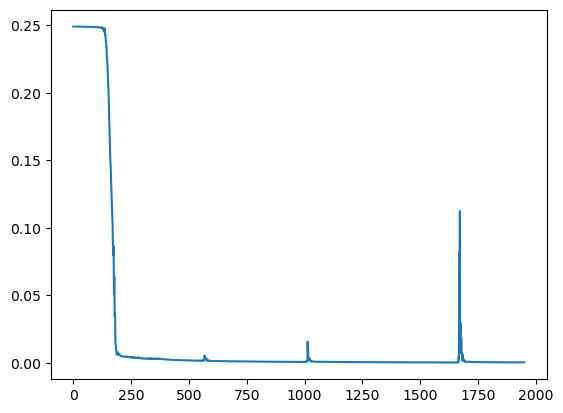

In [7]:
## Train

# Define hyperparameters
n_epochs = 2000
lr = 0.01

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = np.zeros(n_epochs)
val_losses = np.zeros(n_epochs)
# Training Run
for epoch in range(1, n_epochs + 1):
    model.train(optimizer, criterion, inputs_1, outputs_1)
    train_losses[epoch - 1] = model.train(optimizer, criterion, inputs_2, outputs_2)
    val_losses[epoch - 1] = model.train(
        optimizer, criterion, inputs_val, outputs_val, train=False
    )

    if epoch % 10 == 0:
        print("Epoch: {}/{}.............".format(epoch, n_epochs), end=" ")
        print("Loss: {:.5f}".format(train_losses[epoch - 1].item()), end=" ")
        print("Loss: {:.5f}".format(train_losses[epoch - 1].item()))

## Compare loss with out of dataset loss: maybe jumps in loss increase correspond to reduction of ood loss
plt.plot(train_losses[50:])

100%|██████████| 100/100 [00:04<00:00, 22.55it/s]


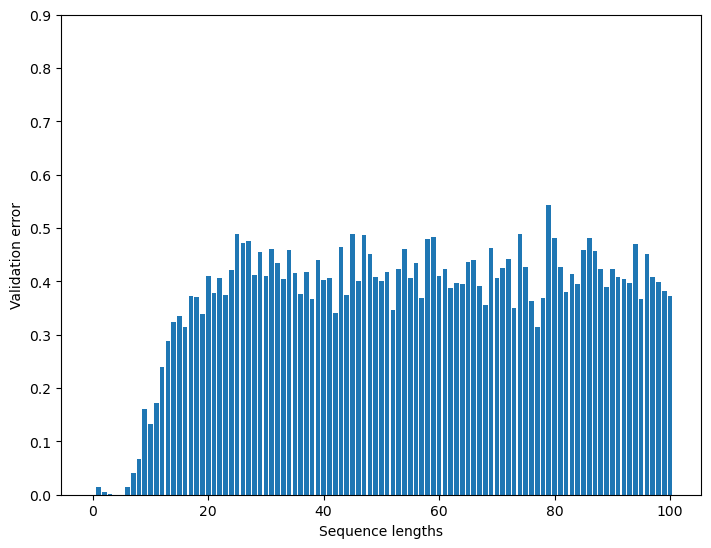

[0.00000000e+00 1.41431568e-02 4.61617298e-03 9.29361791e-04
 5.49851734e-07 5.36448033e-06 1.38754845e-02 4.13152166e-02
 6.64342269e-02 1.60152882e-01 1.32847831e-01 1.72141656e-01
 2.38931343e-01 2.87376136e-01 3.24562907e-01 3.34467232e-01
 3.14631522e-01 3.73446792e-01 3.70679229e-01 3.38620394e-01
 4.09590513e-01 3.77965450e-01 4.05625463e-01 3.74170750e-01
 4.21203911e-01 4.88888085e-01 4.72010493e-01 4.75753427e-01
 4.12457407e-01 4.55282956e-01 4.10364270e-01 4.60831136e-01
 4.33674693e-01 4.04573292e-01 4.58574742e-01 4.15775150e-01
 3.75683814e-01 4.17381585e-01 3.66174012e-01 4.40882444e-01
 4.01996255e-01 4.06681895e-01 3.40074837e-01 4.64940786e-01
 3.73919100e-01 4.89645630e-01 4.01320875e-01 4.87800598e-01
 4.51690197e-01 4.07855749e-01 3.99942994e-01 4.18004155e-01
 3.45904768e-01 4.23165679e-01 4.60747987e-01 4.05729860e-01
 4.34953570e-01 3.68853778e-01 4.78576064e-01 4.83487755e-01
 4.09479082e-01 4.23568666e-01 3.87093663e-01 3.97274911e-01
 3.94962221e-01 4.358889

In [8]:
N = 100
val_err = np.zeros(N + 1)
for n in trange(1, N + 1):
    val_inputs, val_outputs = XOR_data(n_datapoints=100, seq_len=n)
    val_inputs = torch.from_numpy(val_inputs).to(device)
    val_outputs = torch.from_numpy(val_outputs).to(device)
    prediction, _ = model(val_inputs)
    val_err[n] = criterion(torch.squeeze(prediction), torch.squeeze(val_outputs))
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(np.arange(N + 1), val_err)
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation error")
ax.set_yticks(np.arange(0, 1, 0.1))
plt.show()
print(val_err)

In [9]:
def predict(model, sequence):
    input = torch.unsqueeze(
        torch.from_numpy(np.array([sequence], dtype=np.float32)), dim=2
    ).to(device)
    out, hidden = model(input)
    return out

In [10]:
## Predict on dataset
index = 1
input = inputs_1[index]
output = torch.squeeze(outputs_1[index])
prediction, _ = model(torch.unsqueeze(input, dim=0))
prediction = torch.squeeze(prediction)
print(f"Input:{input}")
print(f"Output:{output}")
print(f"Prediction:{prediction}")
print(criterion(prediction, output))

Input:tensor([[0.],
        [0.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
Output:1.0
Prediction:1.0046846866607666
tensor(2.1946e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


In [11]:
print(predict(model, [1,0,1,0]))

tensor([[0.]], device='cuda:0', grad_fn=<ReluBackward0>)
